# Explore emulator configuration
Test EnKF-trained negative log likelihood GPR emulator and introducing a penalty factor for uncertain predictions.

In [1]:
import joblib
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from fatescal.visualize import emulation as emuplt
from fatescal.ces import mcmc

from fatescal.config import PROJECT_ROOT_PATH

In [2]:
# Define paths and file names
training_data_case_name = 'HYY_ST_n128_K4_1D_gpp_et'
kalman_dir = 'kalman_iter_4'
file_stem = 'HYY_ST_vcmax85_bbslope80'

result_dir_path = PROJECT_ROOT_PATH / 'data' / 'results'
plot_save_path = result_dir_path / 'plots' / \
    'publication_results' / 'emulator_config'

feature_matrix_path = result_dir_path / 'emulation' / \
    'feature_matrix' / training_data_case_name
targets_path = result_dir_path / 'emulation' / \
    'targets' / training_data_case_name
emulator_model_path = result_dir_path / 'emulation' / \
    'models' / training_data_case_name

In [3]:
# Read feature matrix and target data
feature_matrix = pd.read_csv(
    feature_matrix_path / f'{file_stem}.csv',
    index_col=0
)

targets_y = pd.read_csv(
    targets_path / f'{file_stem}.csv',
    index_col=0
)

In [4]:
# Load emulator used for mcmc run
emulator_model = joblib.load(
    emulator_model_path / 'gp_regressor.joblib'
)

/cluster/work/users/lassetk/conda_envs/fatescal-env/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
# Split train-test data, same seed as in mcmc run
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix.values,
    targets_y,
    train_size=0.8,
    random_state=221,  # b
    shuffle=True,
)

In [6]:
# Simple evaluation
error_metric_actual = y_test.copy().to_numpy()

error_metric_predictions = emulator_model.predict(
    X_test
).reshape(-1, 1)

<Axes: xlabel='Actual negative log-likelihood', ylabel='Predicted negative log-likelihood'>

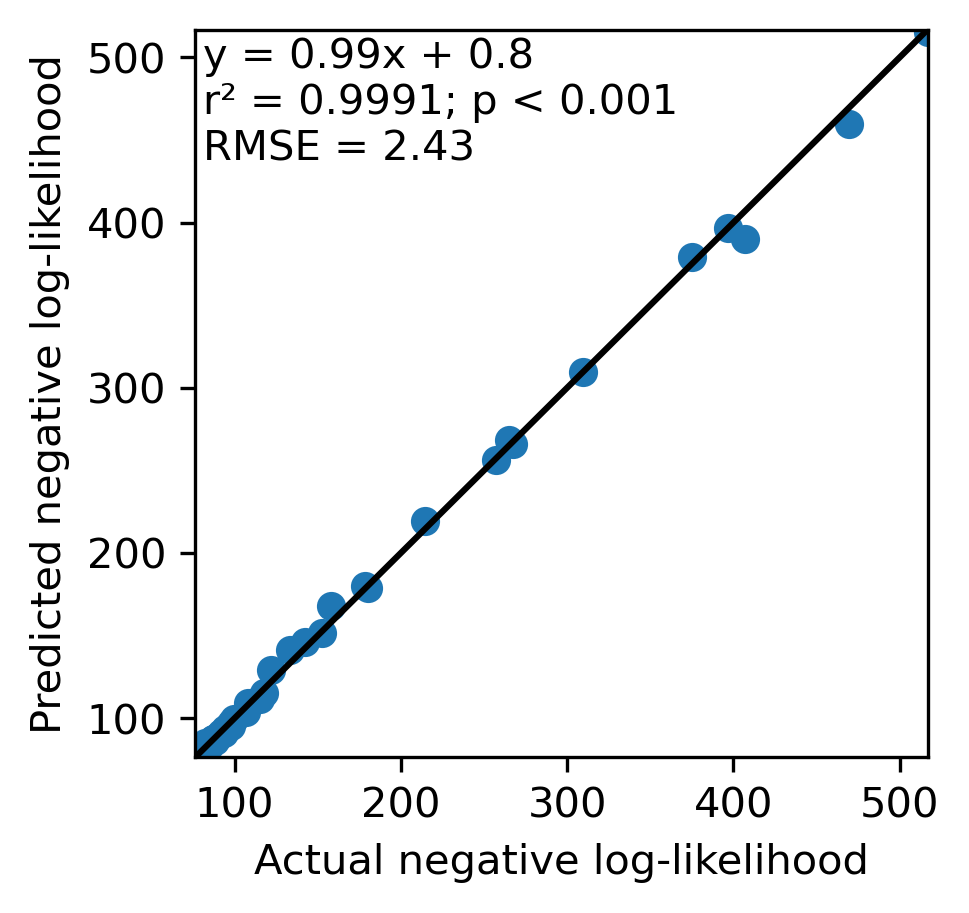

In [7]:
# Plot results
emuplt.plot_emulator_evaluation(
    actual=error_metric_actual,
    predicted=error_metric_predictions,
    metric_code='nll',
    file_name='predicted_vs_actual_nll_1to1.png',
    save_path=plot_save_path,
    save_fig=False,
)

--- 
## Perform MCMC with different penalties

In [8]:
# TEST MCMC
from fatescal.ces import mcmc

penalty_factors = [0, 1, 5]
mcmc_chains = []

for penalty_factor in penalty_factors:

    mcmc_chains.append(
        mcmc.emulator_mcmc(
            starting_parameters=feature_matrix,
            emulator_model=emulator_model,
            scale_nll_by_gpr_std=True,
            std_penalty_factor=penalty_factor,
            save_chain=False,
        )
    )

Finished MCMC iterations: 10000 of 200000 - Time elapsed: 0:00:04.164202
Finished MCMC iterations: 20000 of 200000 - Time elapsed: 0:00:08.219722
Finished MCMC iterations: 30000 of 200000 - Time elapsed: 0:00:12.356737
Finished MCMC iterations: 40000 of 200000 - Time elapsed: 0:00:16.377796
Finished MCMC iterations: 50000 of 200000 - Time elapsed: 0:00:20.410210
Finished MCMC iterations: 60000 of 200000 - Time elapsed: 0:00:24.538903
Finished MCMC iterations: 70000 of 200000 - Time elapsed: 0:00:28.616736
Finished MCMC iterations: 80000 of 200000 - Time elapsed: 0:00:32.603846
Finished MCMC iterations: 90000 of 200000 - Time elapsed: 0:00:36.593774
Finished MCMC iterations: 100000 of 200000 - Time elapsed: 0:00:40.584851
Finished MCMC iterations: 110000 of 200000 - Time elapsed: 0:00:44.569588
Finished MCMC iterations: 120000 of 200000 - Time elapsed: 0:00:48.653165
Finished MCMC iterations: 130000 of 200000 - Time elapsed: 0:00:52.630711
Finished MCMC iterations: 140000 of 200000 - Ti

## Xgboost regressor

In [9]:
# Define hyperparameters to tune
xgboost_params = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "lambda": [1.0, 2.0, 3.0],
    "alpha": [0.0, 1.0, 2.0],
}

In [10]:
# Define xgboost model
xgb_emulator = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    n_jobs=12,  # 16 cores on FRAM login-node
    seed=221,
)

In [11]:
xgboost_grid_search_cv = GridSearchCV(
        xgb_emulator,
        xgboost_params,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=1,
)

_ = xgboost_grid_search_cv.fit(
    X_train,
    y_train.to_numpy().ravel()
)

for k in xgboost_grid_search_cv.best_params_:
    print("Best hyperparameters:")
    print(f"{k}: {xgboost_grid_search_cv.best_params_[k]}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best hyperparameters:
alpha: 2.0
Best hyperparameters:
lambda: 1.0
Best hyperparameters:
learning_rate: 0.2
Best hyperparameters:
max_depth: 4
Best hyperparameters:
n_estimators: 300


In [12]:
# Perform MCMC with tuned XGBOOST regressor
mcmc_chains.append(
    mcmc.emulator_mcmc(
        starting_parameters=feature_matrix,
        emulator_model=xgboost_grid_search_cv.best_estimator_,
        scale_nll_by_gpr_std=False,
        save_chain=False,
    )
)

Finished MCMC iterations: 10000 of 200000 - Time elapsed: 0:00:07.059796
Finished MCMC iterations: 20000 of 200000 - Time elapsed: 0:00:14.056710
Finished MCMC iterations: 30000 of 200000 - Time elapsed: 0:00:20.894191
Finished MCMC iterations: 40000 of 200000 - Time elapsed: 0:00:27.719586
Finished MCMC iterations: 50000 of 200000 - Time elapsed: 0:00:34.525602
Finished MCMC iterations: 60000 of 200000 - Time elapsed: 0:00:41.361557
Finished MCMC iterations: 70000 of 200000 - Time elapsed: 0:00:48.190190
Finished MCMC iterations: 80000 of 200000 - Time elapsed: 0:00:55.011605
Finished MCMC iterations: 90000 of 200000 - Time elapsed: 0:01:01.832758
Finished MCMC iterations: 100000 of 200000 - Time elapsed: 0:01:08.658174
Finished MCMC iterations: 110000 of 200000 - Time elapsed: 0:01:15.479748
Finished MCMC iterations: 120000 of 200000 - Time elapsed: 0:01:22.296213
Finished MCMC iterations: 130000 of 200000 - Time elapsed: 0:01:29.151656
Finished MCMC iterations: 140000 of 200000 - Ti

# Create plot

In [13]:
# Parameter names dictionary
with open(
    result_dir_path.parent / 'dict' / 'param_names.json'
) as j_file:
    param_dict = json.load(j_file)

In [14]:
# Define color scheme
pft_colors = sns.color_palette("colorblind", as_cmap=True)[0:len(mcmc_chains)]

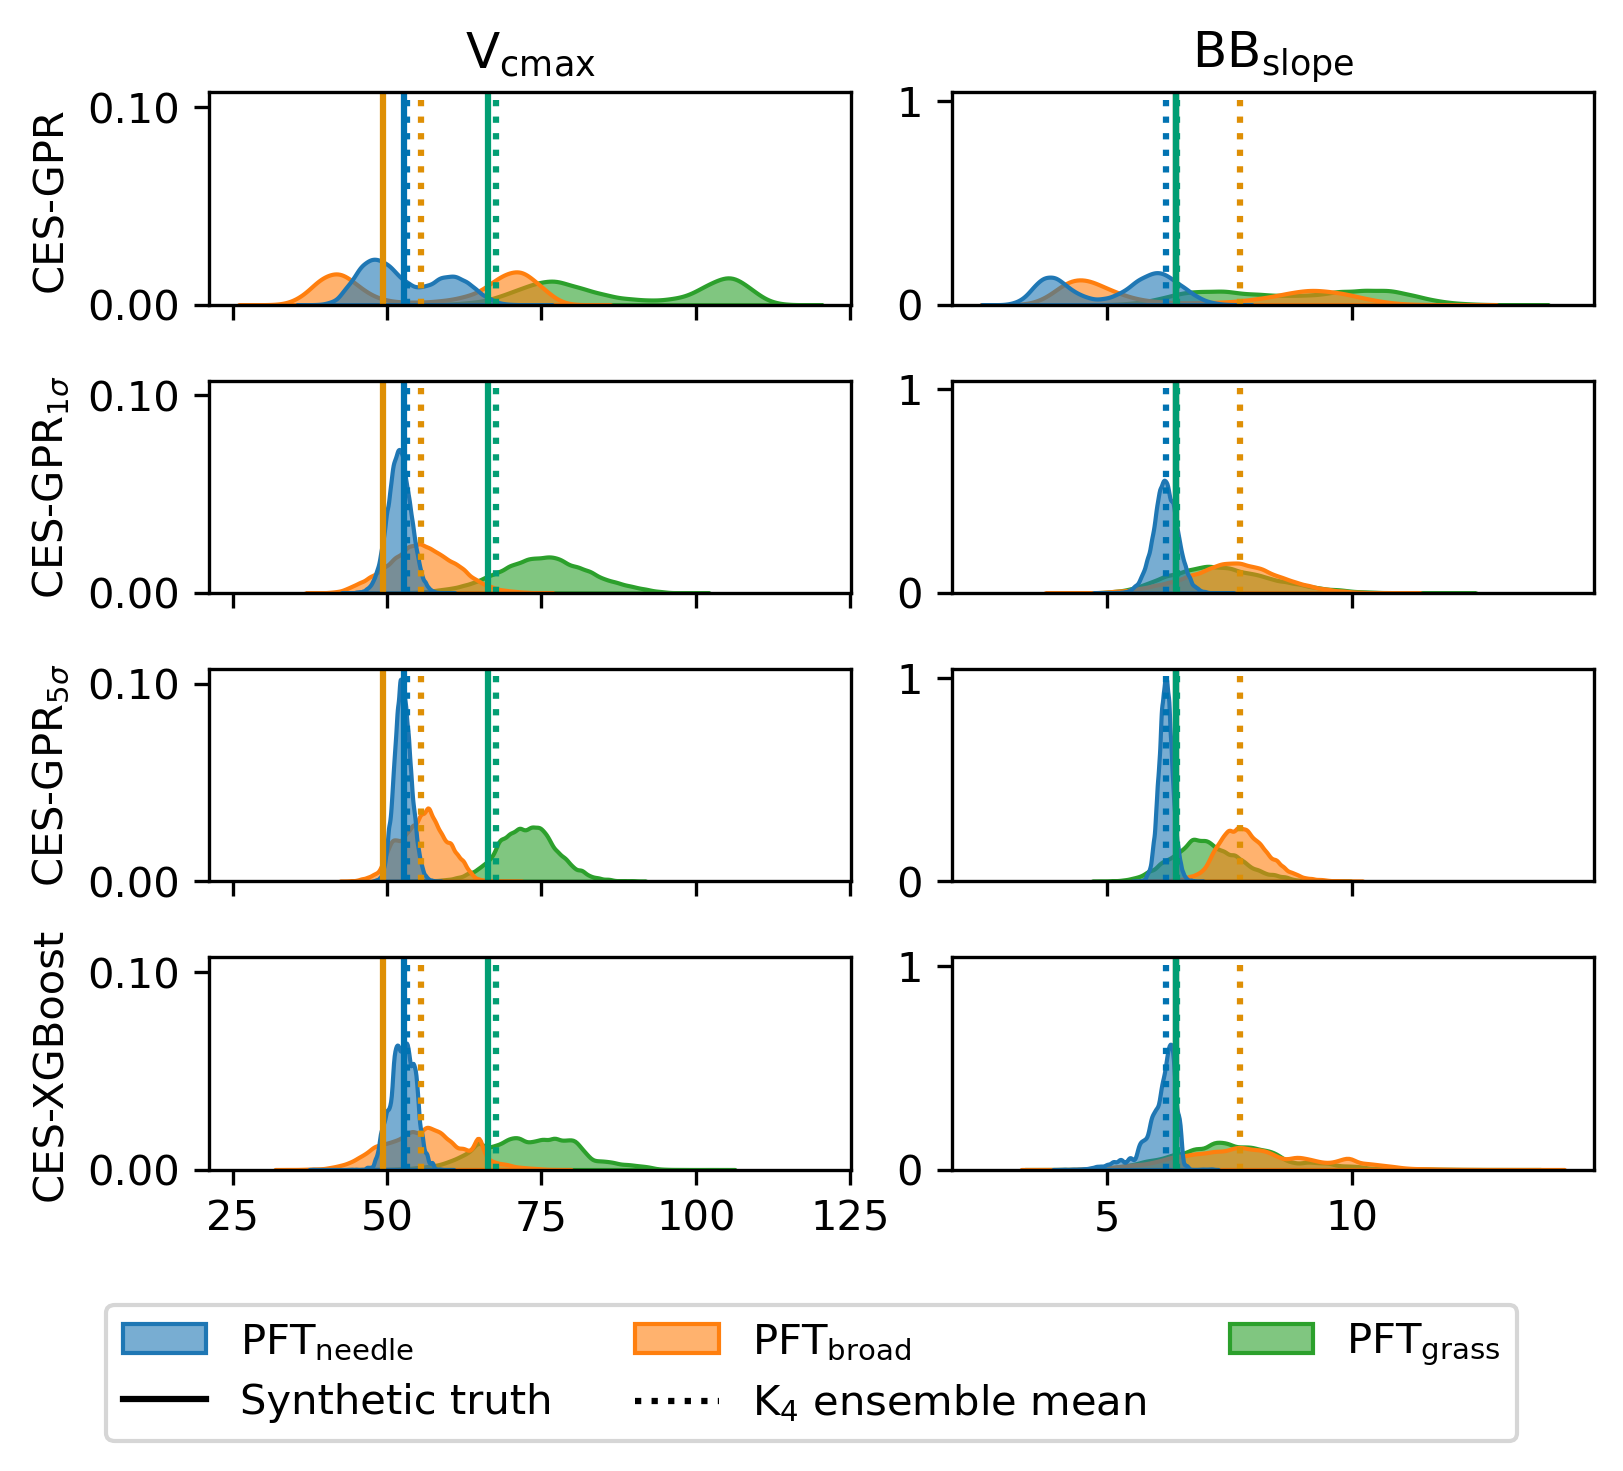

In [17]:
save_fig = True

# Plot with synth_truth and enkf values
synth_truth_vcmax = [52.7, 49.3, 66.3]
synth_truth_bbslope = [6.4, 6.4, 6.4]
enkf_vcmax_ens_means = [53.19, 55.54, 67.68]
enkf_bbslope_ens_means = [6.2, 7.72, 6.43]

fig, axes = plt.subplots(
    nrows=len(mcmc_chains),
    ncols=2,
    sharey='col',
    sharex='col',
    figsize=(14/2.54, 11/2.54),
    dpi=300,
)

for row_idx, df in enumerate(mcmc_chains):

    # Density plot Vcmax
    sns.kdeplot(
        data=df.iloc[:, 0:3],
        ax=axes[row_idx, 0],
        fill=True,
        alpha=0.6,
        legend=False,
        cbar=pft_colors,
    )
    
    # Plot defaults and EnKF ensemble means
    for idx, val in enumerate(synth_truth_vcmax):
        axes[row_idx, 0].axvline(
            val,
            color=pft_colors[idx],
            linestyle="solid",
        )
    for idx, val in enumerate(enkf_vcmax_ens_means):
        axes[row_idx, 0].axvline(
            val,
            color=pft_colors[idx],
            linestyle="dotted",
        )

    sns.kdeplot(
        data=df.iloc[:, 3:],
        ax=axes[row_idx, 1],
        fill=True,
        alpha=0.6,
        legend=False,
        label=["PFT_needle", "PFT_broad", "PFT_grass"],
        cbar=pft_colors,
    )
    # Plot defaults and EnKF ensemble means
    for idx, val in enumerate(synth_truth_bbslope):
        axes[row_idx, 1].axvline(
            val,
            color=pft_colors[idx],
            linestyle="solid",
        )
    for idx, val in enumerate(enkf_bbslope_ens_means):
        axes[row_idx, 1].axvline(
            val,
            color=pft_colors[idx],
            linestyle="dotted",
        )

    #axes[row_idx, 1].set_xlabel("BBslope")
    axes[row_idx, 1].set_ylabel("")

# Format ticks
from matplotlib.ticker import FormatStrFormatter
for idx in range(len(mcmc_chains)):
    axes[idx, 0].yaxis.set_major_formatter(
        FormatStrFormatter('%.2f')
    )

# Add labels
axes[0, 0].set_ylabel(r"CES-GPR")
axes[1, 0].set_ylabel(r"CES-GPR$_{1σ}$")
axes[2, 0].set_ylabel(r"CES-GPR$_{5σ}$")
axes[3, 0].set_ylabel(r"CES-XGBoost")

# Add dummy line artists for legend
axes[0, 1].plot(
    [],
    color="black",
    linestyle="solid",
    label="Synth. truth",
    zorder=-99,
)
axes[0, 1].plot(
    [],
    color="black",
    linestyle="dotted",
    label="EnKF ens. mean",
    zorder=-99,
)

# Add customized figure legend
handles, _ = axes[0, 1].get_legend_handles_labels()
labels = [
    r"PFT$_{\mathrm{needle}}$",
    r"PFT$_{\mathrm{broad}}$",
    r"PFT$_{\mathrm{grass}}$",
    "Synthetic truth",
    "K$_4$ ensemble mean",
]

handles_ordered = [
    handles[2], handles[3], handles[1], handles[4], handles[0]
]
labels_ordered = [
    labels[0], labels[3], labels[1], labels[4], labels[2]
]

fig.legend(
    handles=handles_ordered,
    labels=labels_ordered,
    loc='upper center',
    bbox_to_anchor=(0.5, 0),
    ncol=3
)

axes[0, 0].set_title(r"V$_{\mathrm{cmax}}$")
axes[0, 1].set_title(r"BB$_{\mathrm{slope}}$")

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / "emultor_mcmc_densities.png",
        bbox_inches='tight'
    )

---
# Plot performance

In [18]:
# Simple evaluation
nll_actual = y_test.copy().to_numpy().ravel()

gp_nll_predictions = emulator_model.predict(
    X_test
).ravel()

xgboost_nll_predictions = \
    xgboost_grid_search_cv.best_estimator_.predict(
        X_test
    ).ravel()

In [25]:
from importlib import reload
reload(emuplt)

<module 'fatescal.visualize.emulation' from '/cluster/work/users/lassetk/fates-parameter-calibration/fatescal/visualize/emulation.py'>

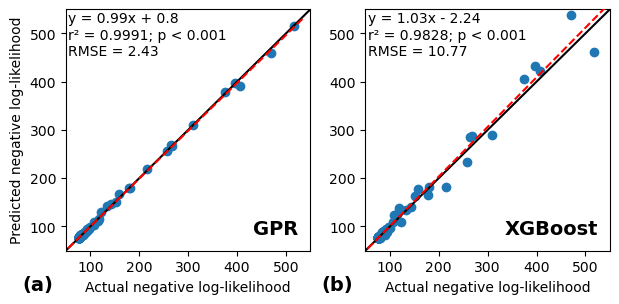

In [27]:
save_fig = True

fig, axes = plt.subplots(
    ncols=2,
    figsize=(16/2.54, 8/2.54)
)

emuplt.plot_emulator_evaluation(
    actual=nll_actual,
    predicted=gp_nll_predictions,
    metric_code='nll',
    file_name='predicted_vs_actual_nll_1to1.png',
    save_path=plot_save_path,
    save_fig=False,
    ax=axes[0],
)

emuplt.plot_emulator_evaluation(
    actual=nll_actual,
    predicted=xgboost_nll_predictions,
    metric_code='nll',
    file_name='predicted_vs_actual_nll_1to1.png',
    save_path=plot_save_path,
    save_fig=False,
    ax=axes[1],
)

lower_limit = 50
upper_limit = 550

axes[0].set_xlim(
    left=lower_limit,
    right=upper_limit,
)
axes[0].set_ylim(
    bottom=lower_limit,
    top=upper_limit,
)

axes[1].set_xlim(
    left=lower_limit,
    right=upper_limit,
)
axes[1].set_ylim(
    bottom=lower_limit,
    top=upper_limit,
)

# Remove label from second plot
axes[1].set_ylabel("")

# Add fig. number and emulator name
axes[0].text(
    0.95, 0.05,
    "GPR",
    ha='right',
    va='bottom',
    transform=axes[0].transAxes,
    fontsize=14,
    fontweight='bold',
)

axes[0].text(
    -0.18, -0.18,
    "(a)",
    ha='left',
    va='bottom',
    transform=axes[0].transAxes,
    fontsize=14,
    fontweight='demibold',
)

axes[1].text(
    0.95, 0.05,
    "XGBoost",
    ha='right',
    va='bottom',
    transform=axes[1].transAxes,
    fontsize=14,
    fontweight='bold',
)

axes[1].text(
    -0.18, -0.18,
    "(b)",
    ha='left',
    va='bottom',
    transform=axes[1].transAxes,
    fontsize=14,
    fontweight='demibold',
)

fig.tight_layout()

if save_fig:
    fig.savefig(
        plot_save_path / 'emulator_performance.png'
    )

In [55]:
# Print kernel hyperparameters
emulator_model.kernel_.get_params()

{'length_scale': 3.264576581910495,
 'length_scale_bounds': (1e-05, 100000.0),
 'nu': 1.5}